# Multi-Agent AlphaDow

This is a notebook to integrate AlphaDow with a multi-agent framework.

In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import pandas as pd
import ray
from ray import tune
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from alphaDow2.envs.facility import MultiStageGenEnv
from alphaDow2 import utils

In [4]:
class MultiAgentSyncEnv(MultiStageGenEnv, MultiAgentEnv):
    '''
    This is a child class of the MultiStageGenEnv class and inherits Ray's
    MultiAgentEnv class to implement a synchronous multi-agent approach for
    the multi-stage scheduling problem. 
    '''
    def __init__(self, *args, **kwargs):
        if 'env_config' in kwargs:
            self.env_config = kwargs['env_config']
        else:
            self.env_config = {}
        super().__init__(env_config=self.env_config)
        
        self.agent_ids = ['_'.join([stage, train]) 
            for stage, train, _ in self.stage_train_list]
        self.num_agents = len(self.agent_ids)
        
        self.state = self.reset()
        
    def step(self, action):
        state, reward, done, info = self._Step(action)
        states = {i: state for i in self.agent_ids}
        rewards = {i: reward for i in self.agent_ids}
        dones = {i: done for i in self.agent_ids}
        dones['__all__'] = done
        infos = {i: info for i in self.agent_ids}
        
        return states, rewards, dones, infos
    
    def reset(self):
        state = self._Reset()
        return {i: state for i in self.agent_ids}
    
env = MultiAgentSyncEnv()

In [5]:
# Test env
env.reset()
while True:
    actions = env.action_space.sample()
    s, r, d, _ = env.step(actions)
    if d['__all__']:
        break

In [4]:
def policy_gen(agent_id):
    return (None, env.observation_space, env.action_space[agent_id], {})

policy_graphs = {f'agent-{i}': policy_gen(i) for i in env.agent_ids}

def policy_mapping_fn(agent_id):
    return f'agent-{agent_id}'

def env_creator(*args, **kwargs):
    return MultiAgentSyncEnv()

env_name = "ADSyncSched"
tune.register_env(env_name, env_creator)

In [5]:
config={
    "log_level": "WARN",
    "num_workers": 3,
    "num_cpus_for_driver": 1,
    "num_cpus_per_worker": 1,
    "lr": 5e-3,
    "model":{"fcnet_hiddens": [128, 128]},
    "multiagent": {
        "policies": policy_graphs,
        "policy_mapping_fn": policy_mapping_fn,
    },
    "env": env_name
}

exp_name = 'ADMultiAgentSync'

exp_dict = {
        'name': exp_name,
        'run_or_experiment': 'PPO',
        "stop": {
            "training_iteration": 100
        },
        'checkpoint_freq': 20,
        "config": config,
}
ray.init(ignore_reinit_error=True)
results = tune.run(**exp_dict)

2020-12-15 09:25:33,802	INFO resource_spec.py:212 -- Starting Ray with 32.28 GiB memory available for workers and up to 16.16 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-12-15 09:25:34,053	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-12-15 09:25:34,302	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
PPO_ADSyncSched_7c8c2_00000,RUNNING,


(pid=29234) 2020-12-15 09:25:37,801	INFO trainer.py:585 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=29234) 2020-12-15 09:25:37,801	INFO trainer.py:612 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=29234) 2020-12-15 09:25:48,177	INFO trainable.py:181 -- _setup took 10.848 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=29234) 2020-12-15 09:25:48,178	WARNING util.py:37 -- Install gputil for GPU system monitoring.
Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-26-02
  done: false
  episode_len_mean: 772.0
  episode_reward_max: 283605.0
  episode_reward_mean: 268735.0
  episode_reward_min: 247905.0
  episodes_this_iter: 3
  episodes_total: 3
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agen

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,1,14.2101,4200,268735


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-26-15
  done: false
  episode_len_mean: 716.2
  episode_reward_max: 321942.0
  episode_reward_mean: 287402.7
  episode_reward_min: 247905.0
  episodes_this_iter: 7
  episodes_total: 10
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.30000001192092896
        cur_lr: 0.004999999888241291
        entropy: 1.3299652338027954
        entropy_coeff: 0.0
        kl: 0.02793634682893753
        model: {}
        policy_loss: 0.004365582950413227
        total_loss: 81841824.0
        vf_explained_var: 9.313225746154785e-09
        vf_loss: 81841824.0
      agent-stage0_train1:
        cur_kl_coeff: 0.30000001192092896
        cur_lr: 0.004999999888241291
        entropy: 1.338819980621338
        entropy_coeff: 0.0
        kl: 0.020550210028886795
        model: {}
        policy_loss: -0.000191212

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,2,27.0696,8400,287403


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-26-27
  done: false
  episode_len_mean: 703.5
  episode_reward_max: 321942.0
  episode_reward_mean: 285660.1875
  episode_reward_min: 247905.0
  episodes_this_iter: 6
  episodes_total: 16
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.44999998807907104
        cur_lr: 0.004999999888241291
        entropy: 1.343700647354126
        entropy_coeff: 0.0
        kl: 0.025928158313035965
        model: {}
        policy_loss: 0.0005663437768816948
        total_loss: 70989056.0
        vf_explained_var: -2.60770320892334e-08
        vf_loss: 70989056.0
      agent-stage0_train1:
        cur_kl_coeff: 0.44999998807907104
        cur_lr: 0.004999999888241291
        entropy: 1.3011822700500488
        entropy_coeff: 0.0
        kl: 0.027135558426380157
        model: {}
        policy_loss: -0.0020

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,3,39.6281,12600,285660


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-26-41
  done: false
  episode_len_mean: 711.6666666666666
  episode_reward_max: 321942.0
  episode_reward_mean: 285839.14285714284
  episode_reward_min: 247905.0
  episodes_this_iter: 5
  episodes_total: 21
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.675000011920929
        cur_lr: 0.004999999888241291
        entropy: 1.3647277355194092
        entropy_coeff: 0.0
        kl: 0.015276411548256874
        model: {}
        policy_loss: -0.003055206034332514
        total_loss: 55613568.0
        vf_explained_var: -5.587935447692871e-09
        vf_loss: 55613568.0
      agent-stage0_train1:
        cur_kl_coeff: 0.675000011920929
        cur_lr: 0.004999999888241291
        entropy: 1.2722229957580566
        entropy_coeff: 0.0
        kl: 0.024950552731752396
        model: {}
        pol

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,4,53.0619,16800,285839


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-26-54
  done: false
  episode_len_mean: 719.8518518518518
  episode_reward_max: 359739.0
  episode_reward_mean: 292720.44444444444
  episode_reward_min: 247905.0
  episodes_this_iter: 6
  episodes_total: 27
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.675000011920929
        cur_lr: 0.004999999888241291
        entropy: 1.3495979309082031
        entropy_coeff: 0.0
        kl: 0.022386644035577774
        model: {}
        policy_loss: 0.00010419241152703762
        total_loss: 92081536.0
        vf_explained_var: 0.0
        vf_loss: 92081536.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.2454273700714111
        entropy_coeff: 0.0
        kl: 0.006880201864987612
        model: {}
        policy_loss: -1.0174

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,5,66.222,21000,292720


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-27-07
  done: false
  episode_len_mean: 714.2424242424242
  episode_reward_max: 380844.0
  episode_reward_mean: 304512.0
  episode_reward_min: 247905.0
  episodes_this_iter: 6
  episodes_total: 33
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.283511757850647
        entropy_coeff: 0.0
        kl: 0.012594873085618019
        model: {}
        policy_loss: -0.0016389070078730583
        total_loss: 114133584.0
        vf_explained_var: -7.450580596923828e-09
        vf_loss: 114133584.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.2405028343200684
        entropy_coeff: 0.0
        kl: 0.012942202389240265
        model: {}
        policy_lo

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,6,78.991,25200,304512


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-27-20
  done: false
  episode_len_mean: 711.3076923076923
  episode_reward_max: 384402.0
  episode_reward_mean: 309110.1538461539
  episode_reward_min: 247905.0
  episodes_this_iter: 6
  episodes_total: 39
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.3127107620239258
        entropy_coeff: 0.0
        kl: 0.009356336668133736
        model: {}
        policy_loss: 0.005688743200153112
        total_loss: 90479368.0
        vf_explained_var: 1.1175870895385742e-08
        vf_loss: 90479368.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.2214874029159546
        entropy_coeff: 0.0
        kl: 0.008932145312428474
        model: {}
        pol

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,7,91.7075,29400,309110


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-27-33
  done: false
  episode_len_mean: 710.2666666666667
  episode_reward_max: 384402.0
  episode_reward_mean: 314078.0
  episode_reward_min: 247905.0
  episodes_this_iter: 6
  episodes_total: 45
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.352473497390747
        entropy_coeff: 0.0
        kl: 0.014137305319309235
        model: {}
        policy_loss: -0.004786821082234383
        total_loss: 93559952.0
        vf_explained_var: 3.725290298461914e-09
        vf_loss: 93559952.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.2359251976013184
        entropy_coeff: 0.0
        kl: 0.007976200431585312
        model: {}
        policy_loss: 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,8,104.6,33600,314078


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-27-46
  done: false
  episode_len_mean: 712.2941176470588
  episode_reward_max: 388584.0
  episode_reward_mean: 318983.4705882353
  episode_reward_min: 247905.0
  episodes_this_iter: 6
  episodes_total: 51
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.3374602794647217
        entropy_coeff: 0.0
        kl: 0.006471266504377127
        model: {}
        policy_loss: -0.004233758430927992
        total_loss: 90685808.0
        vf_explained_var: 9.313225746154785e-09
        vf_loss: 90685808.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.206902265548706
        entropy_coeff: 0.0
        kl: 0.015423308126628399
        model: {}
        poli

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,9,117.845,37800,318983


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-27-59
  done: false
  episode_len_mean: 708.3508771929825
  episode_reward_max: 388584.0
  episode_reward_mean: 321048.0
  episode_reward_min: 247905.0
  episodes_this_iter: 6
  episodes_total: 57
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.3112157583236694
        entropy_coeff: 0.0
        kl: 0.014471384696662426
        model: {}
        policy_loss: -0.009466606192290783
        total_loss: 111349392.0
        vf_explained_var: -5.587935447692871e-09
        vf_loss: 111349392.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.170749545097351
        entropy_coeff: 0.0
        kl: 0.008995383977890015
        model: {}
        policy_los

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,10,131.215,42000,321048


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-28-12
  done: false
  episode_len_mean: 692.939393939394
  episode_reward_max: 388584.0
  episode_reward_mean: 310533.13636363635
  episode_reward_min: 1023.0
  episodes_this_iter: 9
  episodes_total: 66
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.2624142169952393
        entropy_coeff: 0.0
        kl: 0.010860410518944263
        model: {}
        policy_loss: -0.0016686003655195236
        total_loss: 82423688.0
        vf_explained_var: -9.313225746154785e-09
        vf_loss: 82423688.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1166658401489258
        entropy_coeff: 0.0
        kl: 0.00969550758600235
        model: {}
        poli

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,11,144.226,46200,310533


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-28-25
  done: false
  episode_len_mean: 679.0958904109589
  episode_reward_max: 388932.0
  episode_reward_mean: 316077.7397260274
  episode_reward_min: 1023.0
  episodes_this_iter: 7
  episodes_total: 73
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.252145528793335
        entropy_coeff: 0.0
        kl: 0.0147372642531991
        model: {}
        policy_loss: 0.0031618699431419373
        total_loss: 183244032.0
        vf_explained_var: -1.30385160446167e-08
        vf_loss: 183244032.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1008751392364502
        entropy_coeff: 0.0
        kl: 0.008633537217974663
        model: {}
        policy

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,12,157.116,50400,316078


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-28-39
  done: false
  episode_len_mean: 665.5185185185185
  episode_reward_max: 390237.0
  episode_reward_mean: 321489.0
  episode_reward_min: 1023.0
  episodes_this_iter: 8
  episodes_total: 81
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.2889777421951294
        entropy_coeff: 0.0
        kl: 0.0068427459336817265
        model: {}
        policy_loss: -0.003912094049155712
        total_loss: 181769888.0
        vf_explained_var: -1.30385160446167e-08
        vf_loss: 181769888.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1405597925186157
        entropy_coeff: 0.0
        kl: 0.012117834761738777
        model: {}
        policy_loss

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,13,170.718,54600,321489


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-28-53
  done: false
  episode_len_mean: 656.625
  episode_reward_max: 390237.0
  episode_reward_mean: 325049.25
  episode_reward_min: 1023.0
  episodes_this_iter: 7
  episodes_total: 88
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.3060574531555176
        entropy_coeff: 0.0
        kl: 0.012340176850557327
        model: {}
        policy_loss: -0.008046197704970837
        total_loss: 160853152.0
        vf_explained_var: -1.4901161193847656e-08
        vf_loss: 160853152.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1109907627105713
        entropy_coeff: 0.0
        kl: 0.007502542808651924
        model: {}
        policy_loss: 0.0007

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,14,184.245,58800,325049


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-29-06
  done: false
  episode_len_mean: 646.6354166666666
  episode_reward_max: 404694.0
  episode_reward_mean: 323156.90625
  episode_reward_min: 1023.0
  episodes_this_iter: 8
  episodes_total: 96
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.2544571161270142
        entropy_coeff: 0.0
        kl: 0.011585218831896782
        model: {}
        policy_loss: 0.0007476822938770056
        total_loss: 101374960.0
        vf_explained_var: -1.1175870895385742e-08
        vf_loss: 101374960.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.0656346082687378
        entropy_coeff: 0.0
        kl: 0.01233847625553608
        model: {}
        policy_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,15,197.271,63000,323157


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-29-19
  done: false
  episode_len_mean: 629.1
  episode_reward_max: 404694.0
  episode_reward_mean: 296424.48
  episode_reward_min: -355500.0
  episodes_this_iter: 9
  episodes_total: 105
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.214457631111145
        entropy_coeff: 0.0
        kl: 0.009953013621270657
        model: {}
        policy_loss: -0.005117571912705898
        total_loss: 127827256.0
        vf_explained_var: -2.0489096641540527e-08
        vf_loss: 127827256.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.0001482963562012
        entropy_coeff: 0.0
        kl: 0.011444389820098877
        model: {}
        policy_loss: 0.004

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,16,210.333,67200,296424


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-29-32
  done: false
  episode_len_mean: 615.5
  episode_reward_max: 404694.0
  episode_reward_mean: 292027.5
  episode_reward_min: -355500.0
  episodes_this_iter: 8
  episodes_total: 113
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.23794424533844
        entropy_coeff: 0.0
        kl: 0.009181461296975613
        model: {}
        policy_loss: -0.0025042779743671417
        total_loss: 154905920.0
        vf_explained_var: 1.30385160446167e-08
        vf_loss: 154905920.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.0683614015579224
        entropy_coeff: 0.0
        kl: 0.007349672261625528
        model: {}
        policy_loss: -3.928644

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,17,223.72,71400,292028


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-29-45
  done: false
  episode_len_mean: 598.43
  episode_reward_max: 404694.0
  episode_reward_mean: 295675.89
  episode_reward_min: -355500.0
  episodes_this_iter: 8
  episodes_total: 121
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.2208409309387207
        entropy_coeff: 0.0
        kl: 0.010607204400002956
        model: {}
        policy_loss: 0.004823475144803524
        total_loss: 177024112.0
        vf_explained_var: 5.587935447692871e-09
        vf_loss: 177024112.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.009676218032837
        entropy_coeff: 0.0
        kl: 0.01150763500481844
        model: {}
        policy_loss: 0.002660

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,18,236.744,75600,295676


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-29-59
  done: false
  episode_len_mean: 582.35
  episode_reward_max: 404694.0
  episode_reward_mean: 295959.81
  episode_reward_min: -355500.0
  episodes_this_iter: 8
  episodes_total: 129
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.2582893371582031
        entropy_coeff: 0.0
        kl: 0.008823813870549202
        model: {}
        policy_loss: -0.004412564914673567
        total_loss: 160302160.0
        vf_explained_var: 1.862645149230957e-08
        vf_loss: 160302160.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.008171558380127
        entropy_coeff: 0.0
        kl: 0.00897236354649067
        model: {}
        policy_loss: -0.0027

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,19,249.925,79800,295960


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-30-12
  done: false
  episode_len_mean: 565.36
  episode_reward_max: 404694.0
  episode_reward_mean: 277764.63
  episode_reward_min: -355500.0
  episodes_this_iter: 9
  episodes_total: 138
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1813830137252808
        entropy_coeff: 0.0
        kl: 0.013538362458348274
        model: {}
        policy_loss: 0.0014542192220687866
        total_loss: 133301768.0
        vf_explained_var: -1.862645149230957e-09
        vf_loss: 133301768.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 0.9839160442352295
        entropy_coeff: 0.0
        kl: 0.010278625413775444
        model: {}
        policy_loss: 0.00

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,20,263.011,84000,277765


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-30-25
  done: false
  episode_len_mean: 551.8
  episode_reward_max: 404694.0
  episode_reward_mean: 265318.71
  episode_reward_min: -355500.0
  episodes_this_iter: 7
  episodes_total: 145
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1111998558044434
        entropy_coeff: 0.0
        kl: 0.017209092155098915
        model: {}
        policy_loss: -0.00019862595945596695
        total_loss: 96150752.0
        vf_explained_var: -5.587935447692871e-09
        vf_loss: 96150752.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.0285282135009766
        entropy_coeff: 0.0
        kl: 0.008115935139358044
        model: {}
        policy_loss: 0.001

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,21,276.27,88200,265319


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-30-39
  done: false
  episode_len_mean: 530.65
  episode_reward_max: 404694.0
  episode_reward_mean: 241406.91
  episode_reward_min: -355500.0
  episodes_this_iter: 9
  episodes_total: 154
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.085221290588379
        entropy_coeff: 0.0
        kl: 0.009380446746945381
        model: {}
        policy_loss: 0.005392966791987419
        total_loss: 150267584.0
        vf_explained_var: 3.725290298461914e-09
        vf_loss: 150267584.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.068947196006775
        entropy_coeff: 0.0
        kl: 0.009473268873989582
        model: {}
        policy_loss: 0.002613

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,22,289.625,92400,241407


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-30-52
  done: false
  episode_len_mean: 521.06
  episode_reward_max: 404694.0
  episode_reward_mean: 225365.07
  episode_reward_min: -355500.0
  episodes_this_iter: 8
  episodes_total: 162
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1118688583374023
        entropy_coeff: 0.0
        kl: 0.007748397067189217
        model: {}
        policy_loss: -0.0025833945255726576
        total_loss: 128848560.0
        vf_explained_var: 1.1175870895385742e-08
        vf_loss: 128848560.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.0906096696853638
        entropy_coeff: 0.0
        kl: 0.00913973804563284
        model: {}
        policy_loss: 0.00

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,23,303.393,96600,225365


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-31-07
  done: false
  episode_len_mean: 514.84
  episode_reward_max: 404694.0
  episode_reward_mean: 171155.76
  episode_reward_min: -1045410.0
  episodes_this_iter: 9
  episodes_total: 171
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.0180665254592896
        entropy_coeff: 0.0
        kl: 0.009847468696534634
        model: {}
        policy_loss: -0.0007204324938356876
        total_loss: 675624768.0
        vf_explained_var: -1.862645149230957e-09
        vf_loss: 675624768.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 0.9426760077476501
        entropy_coeff: 0.0
        kl: 0.005714052356779575
        model: {}
        policy_loss: 0.

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,24,317.743,100800,171156


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-31-21
  done: false
  episode_len_mean: 507.94
  episode_reward_max: 404694.0
  episode_reward_mean: 94912.77
  episode_reward_min: -1045410.0
  episodes_this_iter: 9
  episodes_total: 180
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 0.8884502053260803
        entropy_coeff: 0.0
        kl: 0.005336248315870762
        model: {}
        policy_loss: 0.0006147054955363274
        total_loss: 944541440.0
        vf_explained_var: -2.2351741790771484e-08
        vf_loss: 944541440.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.0202422142028809
        entropy_coeff: 0.0
        kl: 0.010226164013147354
        model: {}
        policy_loss: -0.

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,25,331.388,105000,94912.8


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-31-35
  done: false
  episode_len_mean: 501.27
  episode_reward_max: 388446.0
  episode_reward_mean: -15529.32
  episode_reward_min: -1264212.0
  episodes_this_iter: 9
  episodes_total: 189
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 0.7069255709648132
        entropy_coeff: 0.0
        kl: 0.0035540577955543995
        model: {}
        policy_loss: 0.0008265934884548187
        total_loss: 2249603584.0
        vf_explained_var: -1.4901161193847656e-08
        vf_loss: 2249603584.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 0.972669780254364
        entropy_coeff: 0.0
        kl: 0.008058829233050346
        model: {}
        policy_loss: 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,26,345.596,109200,-15529.3


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-31-50
  done: false
  episode_len_mean: 500.4
  episode_reward_max: 381519.0
  episode_reward_mean: -109399.5
  episode_reward_min: -1264212.0
  episodes_this_iter: 9
  episodes_total: 198
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.5062500238418579
        cur_lr: 0.004999999888241291
        entropy: 0.7773417234420776
        entropy_coeff: 0.0
        kl: 0.006421894766390324
        model: {}
        policy_loss: 0.0012248354032635689
        total_loss: 1708081152.0
        vf_explained_var: -1.6763806343078613e-08
        vf_loss: 1708081152.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.0611640214920044
        entropy_coeff: 0.0
        kl: 0.008248252794146538
        model: {}
        policy_loss: -

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,27,360.544,113400,-109400


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-32-03
  done: false
  episode_len_mean: 502.38
  episode_reward_max: 381519.0
  episode_reward_mean: -148812.69
  episode_reward_min: -1264212.0
  episodes_this_iter: 6
  episodes_total: 204
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.5062500238418579
        cur_lr: 0.004999999888241291
        entropy: 0.6744680404663086
        entropy_coeff: 0.0
        kl: 0.007300335448235273
        model: {}
        policy_loss: 0.005616647191345692
        total_loss: 1053337984.0
        vf_explained_var: 5.587935447692871e-09
        vf_loss: 1053337984.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1417994499206543
        entropy_coeff: 0.0
        kl: 0.0072213090024888515
        model: {}
        policy_loss: 0

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,28,373.683,117600,-148813


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-32-17
  done: false
  episode_len_mean: 506.56
  episode_reward_max: 381519.0
  episode_reward_mean: -176913.87
  episode_reward_min: -1264212.0
  episodes_this_iter: 9
  episodes_total: 213
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.5062500238418579
        cur_lr: 0.004999999888241291
        entropy: 0.838301420211792
        entropy_coeff: 0.0
        kl: 0.008049704134464264
        model: {}
        policy_loss: 0.0010860953480005264
        total_loss: 165438000.0
        vf_explained_var: 1.862645149230957e-09
        vf_loss: 165438000.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1621077060699463
        entropy_coeff: 0.0
        kl: 0.012017675675451756
        model: {}
        policy_loss: 0.00

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,29,387.213,121800,-176914


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-32-31
  done: false
  episode_len_mean: 513.09
  episode_reward_max: 381519.0
  episode_reward_mean: -184188.42
  episode_reward_min: -1264212.0
  episodes_this_iter: 6
  episodes_total: 219
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.5062500238418579
        cur_lr: 0.004999999888241291
        entropy: 0.8451752066612244
        entropy_coeff: 0.0
        kl: 0.011233896017074585
        model: {}
        policy_loss: 0.008418424986302853
        total_loss: 60551056.0
        vf_explained_var: -9.313225746154785e-09
        vf_loss: 60551056.0
      agent-stage0_train1:
        cur_kl_coeff: 1.0125000476837158
        cur_lr: 0.004999999888241291
        entropy: 1.1578483581542969
        entropy_coeff: 0.0
        kl: 0.024608202278614044
        model: {}
        policy_loss: 0.003

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,30,401.16,126000,-184188


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-32-44
  done: false
  episode_len_mean: 520.33
  episode_reward_max: 381519.0
  episode_reward_mean: -194325.09
  episode_reward_min: -1264212.0
  episodes_this_iter: 6
  episodes_total: 225
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.5062500238418579
        cur_lr: 0.004999999888241291
        entropy: 0.7390443682670593
        entropy_coeff: 0.0
        kl: 0.009094415232539177
        model: {}
        policy_loss: 0.004232407547533512
        total_loss: 52978720.0
        vf_explained_var: 1.6763806343078613e-08
        vf_loss: 52978720.0
      agent-stage0_train1:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 0.004999999888241291
        entropy: 1.1707606315612793
        entropy_coeff: 0.0
        kl: 0.011822761967778206
        model: {}
        policy_loss: -5.91

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,31,414.022,130200,-194325


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-32-57
  done: false
  episode_len_mean: 528.48
  episode_reward_max: 365049.0
  episode_reward_mean: -193336.86
  episode_reward_min: -1264212.0
  episodes_this_iter: 7
  episodes_total: 232
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.5062500238418579
        cur_lr: 0.004999999888241291
        entropy: 0.7507752180099487
        entropy_coeff: 0.0
        kl: 0.0034549294505268335
        model: {}
        policy_loss: 0.0014220895245671272
        total_loss: 89437296.0
        vf_explained_var: 1.862645149230957e-09
        vf_loss: 89437296.0
      agent-stage0_train1:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 0.004999999888241291
        entropy: 1.1543588638305664
        entropy_coeff: 0.0
        kl: 0.00879085436463356
        model: {}
        policy_loss: 0.002

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,32,426.829,134400,-193337


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-33-10
  done: false
  episode_len_mean: 534.47
  episode_reward_max: 367467.0
  episode_reward_mean: -182137.65
  episode_reward_min: -1264212.0
  episodes_this_iter: 8
  episodes_total: 240
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.25312501192092896
        cur_lr: 0.004999999888241291
        entropy: 0.7220034599304199
        entropy_coeff: 0.0
        kl: 0.01923440583050251
        model: {}
        policy_loss: 0.009240644983947277
        total_loss: 89880736.0
        vf_explained_var: -1.6763806343078613e-08
        vf_loss: 89880736.0
      agent-stage0_train1:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 0.004999999888241291
        entropy: 1.1706637144088745
        entropy_coeff: 0.0
        kl: 0.007139204535633326
        model: {}
        policy_loss: 0.00

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,33,439.772,138600,-182138


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-33-23
  done: false
  episode_len_mean: 537.68
  episode_reward_max: 367467.0
  episode_reward_mean: -197379.03
  episode_reward_min: -1264212.0
  episodes_this_iter: 7
  episodes_total: 247
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.25312501192092896
        cur_lr: 0.004999999888241291
        entropy: 0.5936481952667236
        entropy_coeff: 0.0
        kl: 0.023666122928261757
        model: {}
        policy_loss: 0.01451393123716116
        total_loss: 311310912.0
        vf_explained_var: 2.60770320892334e-08
        vf_loss: 311310912.0
      agent-stage0_train1:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 0.004999999888241291
        entropy: 1.1756200790405273
        entropy_coeff: 0.0
        kl: 0.009924471378326416
        model: {}
        policy_loss: -0.00

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,34,452.735,142800,-197379


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-33-36
  done: false
  episode_len_mean: 543.73
  episode_reward_max: 367467.0
  episode_reward_mean: -228582.0
  episode_reward_min: -1264212.0
  episodes_this_iter: 8
  episodes_total: 255
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.37968748807907104
        cur_lr: 0.004999999888241291
        entropy: 0.5228270292282104
        entropy_coeff: 0.0
        kl: 0.008963287808001041
        model: {}
        policy_loss: 0.0033739260397851467
        total_loss: 299068320.0
        vf_explained_var: -9.313225746154785e-09
        vf_loss: 299068320.0
      agent-stage0_train1:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 0.004999999888241291
        entropy: 1.172200322151184
        entropy_coeff: 0.0
        kl: 0.008629901334643364
        model: {}
        policy_loss: -0.

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,35,466.14,147000,-228582


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-33-51
  done: false
  episode_len_mean: 547.03
  episode_reward_max: 367467.0
  episode_reward_mean: -253478.1
  episode_reward_min: -1264212.0
  episodes_this_iter: 8
  episodes_total: 263
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.37968748807907104
        cur_lr: 0.004999999888241291
        entropy: 0.4513266682624817
        entropy_coeff: 0.0
        kl: 0.00895717367529869
        model: {}
        policy_loss: 0.00983350072056055
        total_loss: 317265696.0
        vf_explained_var: -2.0489096641540527e-08
        vf_loss: 317265696.0
      agent-stage0_train1:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 0.004999999888241291
        entropy: 1.1654186248779297
        entropy_coeff: 0.0
        kl: 0.01223238930106163
        model: {}
        policy_loss: -0.00

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,36,480.899,151200,-253478


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-34-04
  done: false
  episode_len_mean: 553.84
  episode_reward_max: 367467.0
  episode_reward_mean: -240243.69
  episode_reward_min: -1264212.0
  episodes_this_iter: 7
  episodes_total: 270
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.37968748807907104
        cur_lr: 0.004999999888241291
        entropy: 0.5049195289611816
        entropy_coeff: 0.0
        kl: 0.009103003889322281
        model: {}
        policy_loss: 0.0050999755039811134
        total_loss: 130897296.0
        vf_explained_var: -2.60770320892334e-08
        vf_loss: 130897296.0
      agent-stage0_train1:
        cur_kl_coeff: 1.5187499523162842
        cur_lr: 0.004999999888241291
        entropy: 1.1983776092529297
        entropy_coeff: 0.0
        kl: 0.004244795069098473
        model: {}
        policy_loss: -0

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,37,493.693,155400,-240244


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-34-17
  done: false
  episode_len_mean: 561.67
  episode_reward_max: 367467.0
  episode_reward_mean: -229931.73
  episode_reward_min: -1264212.0
  episodes_this_iter: 6
  episodes_total: 276
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.37968748807907104
        cur_lr: 0.004999999888241291
        entropy: 0.3666011691093445
        entropy_coeff: 0.0
        kl: 0.0022515032906085253
        model: {}
        policy_loss: -0.0004920987412333488
        total_loss: 286247040.0
        vf_explained_var: 1.1175870895385742e-08
        vf_loss: 286247040.0
      agent-stage0_train1:
        cur_kl_coeff: 0.7593749761581421
        cur_lr: 0.004999999888241291
        entropy: 1.1703400611877441
        entropy_coeff: 0.0
        kl: 0.009802810847759247
        model: {}
        policy_loss:

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,38,506.617,159600,-229932


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-34-30
  done: false
  episode_len_mean: 567.15
  episode_reward_max: 367467.0
  episode_reward_mean: -223404.57
  episode_reward_min: -1153008.0
  episodes_this_iter: 9
  episodes_total: 285
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.18984374403953552
        cur_lr: 0.004999999888241291
        entropy: 0.3154633939266205
        entropy_coeff: 0.0
        kl: 0.014938590116798878
        model: {}
        policy_loss: 0.003301195800304413
        total_loss: 1030447616.0
        vf_explained_var: 5.587935447692871e-09
        vf_loss: 1030447616.0
      agent-stage0_train1:
        cur_kl_coeff: 0.7593749761581421
        cur_lr: 0.004999999888241291
        entropy: 1.1732451915740967
        entropy_coeff: 0.0
        kl: 0.011451571248471737
        model: {}
        policy_loss: -

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,39,519.509,163800,-223405


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-34-43
  done: false
  episode_len_mean: 568.32
  episode_reward_max: 367467.0
  episode_reward_mean: -189224.94
  episode_reward_min: -950982.0
  episodes_this_iter: 9
  episodes_total: 294
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.18984374403953552
        cur_lr: 0.004999999888241291
        entropy: 0.2854801416397095
        entropy_coeff: 0.0
        kl: 0.04292096942663193
        model: {}
        policy_loss: 0.005894351750612259
        total_loss: 937011904.0
        vf_explained_var: 1.30385160446167e-08
        vf_loss: 937011904.0
      agent-stage0_train1:
        cur_kl_coeff: 0.7593749761581421
        cur_lr: 0.004999999888241291
        entropy: 1.147750735282898
        entropy_coeff: 0.0
        kl: 0.014350459910929203
        model: {}
        policy_loss: -0.0015

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,40,532.543,168000,-189225


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-34-56
  done: false
  episode_len_mean: 567.86
  episode_reward_max: 367467.0
  episode_reward_mean: -168381.72
  episode_reward_min: -950982.0
  episodes_this_iter: 6
  episodes_total: 300
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.2847656309604645
        cur_lr: 0.004999999888241291
        entropy: 0.35558995604515076
        entropy_coeff: 0.0
        kl: 0.006909715943038464
        model: {}
        policy_loss: 0.0011941799893975258
        total_loss: 460347520.0
        vf_explained_var: -9.313225746154785e-09
        vf_loss: 460347520.0
      agent-stage0_train1:
        cur_kl_coeff: 0.7593749761581421
        cur_lr: 0.004999999888241291
        entropy: 1.1919538974761963
        entropy_coeff: 0.0
        kl: 0.008156543597579002
        model: {}
        policy_loss: 0.

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,41,545.431,172200,-168382


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-35-09
  done: false
  episode_len_mean: 570.3
  episode_reward_max: 367467.0
  episode_reward_mean: -167873.97
  episode_reward_min: -790236.0
  episodes_this_iter: 9
  episodes_total: 309
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.2847656309604645
        cur_lr: 0.004999999888241291
        entropy: 0.2644461989402771
        entropy_coeff: 0.0
        kl: 0.002563083078712225
        model: {}
        policy_loss: -0.0006207031547091901
        total_loss: 498126144.0
        vf_explained_var: -7.450580596923828e-09
        vf_loss: 498126144.0
      agent-stage0_train1:
        cur_kl_coeff: 0.7593749761581421
        cur_lr: 0.004999999888241291
        entropy: 1.161379337310791
        entropy_coeff: 0.0
        kl: 0.012293214909732342
        model: {}
        policy_loss: 0.00

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,42,558.308,176400,-167874


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-35-22
  done: false
  episode_len_mean: 568.86
  episode_reward_max: 367467.0
  episode_reward_mean: -198865.02
  episode_reward_min: -790236.0
  episodes_this_iter: 6
  episodes_total: 315
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.14238281548023224
        cur_lr: 0.004999999888241291
        entropy: 0.25541844964027405
        entropy_coeff: 0.0
        kl: 0.0032194440718740225
        model: {}
        policy_loss: 0.0005071591585874557
        total_loss: 414420896.0
        vf_explained_var: 1.862645149230957e-09
        vf_loss: 414420896.0
      agent-stage0_train1:
        cur_kl_coeff: 0.7593749761581421
        cur_lr: 0.004999999888241291
        entropy: 1.1995670795440674
        entropy_coeff: 0.0
        kl: 0.0274873785674572
        model: {}
        policy_loss: 0.0

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,43,571.128,180600,-198865


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-35-35
  done: false
  episode_len_mean: 565.13
  episode_reward_max: 367467.0
  episode_reward_mean: -252462.21
  episode_reward_min: -1101903.0
  episodes_this_iter: 7
  episodes_total: 322
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.07119140774011612
        cur_lr: 0.004999999888241291
        entropy: 0.27512305974960327
        entropy_coeff: 0.0
        kl: 0.0037526553496718407
        model: {}
        policy_loss: -0.0024413233622908592
        total_loss: 1186223360.0
        vf_explained_var: -5.587935447692871e-09
        vf_loss: 1186223360.0
      agent-stage0_train1:
        cur_kl_coeff: 1.139062523841858
        cur_lr: 0.004999999888241291
        entropy: 1.224684715270996
        entropy_coeff: 0.0
        kl: 0.00776016665622592
        model: {}
        policy_loss:

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,44,583.967,184800,-252462


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-35-48
  done: false
  episode_len_mean: 561.61
  episode_reward_max: 367467.0
  episode_reward_mean: -317804.43
  episode_reward_min: -1101903.0
  episodes_this_iter: 8
  episodes_total: 330
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.03559570387005806
        cur_lr: 0.004999999888241291
        entropy: 0.43674764037132263
        entropy_coeff: 0.0
        kl: 0.024540605023503304
        model: {}
        policy_loss: 0.008261153474450111
        total_loss: 583589440.0
        vf_explained_var: 2.2351741790771484e-08
        vf_loss: 583589440.0
      agent-stage0_train1:
        cur_kl_coeff: 1.139062523841858
        cur_lr: 0.004999999888241291
        entropy: 1.238977313041687
        entropy_coeff: 0.0
        kl: 0.008289754390716553
        model: {}
        policy_loss: 0.0

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,45,597.034,189000,-317804


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-36-01
  done: false
  episode_len_mean: 557.55
  episode_reward_max: 318363.0
  episode_reward_mean: -399525.15
  episode_reward_min: -1189590.0
  episodes_this_iter: 7
  episodes_total: 337
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.05339355394244194
        cur_lr: 0.004999999888241291
        entropy: 0.14446097612380981
        entropy_coeff: 0.0
        kl: 0.028607357293367386
        model: {}
        policy_loss: 0.010213583707809448
        total_loss: 2423133696.0
        vf_explained_var: -5.587935447692871e-09
        vf_loss: 2423133696.0
      agent-stage0_train1:
        cur_kl_coeff: 1.139062523841858
        cur_lr: 0.004999999888241291
        entropy: 1.2027487754821777
        entropy_coeff: 0.0
        kl: 0.009856005199253559
        model: {}
        policy_loss: 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,46,609.963,193200,-399525


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-36-14
  done: false
  episode_len_mean: 554.31
  episode_reward_max: 24519.0
  episode_reward_mean: -524816.46
  episode_reward_min: -1792617.0
  episodes_this_iter: 9
  episodes_total: 346
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.08009032905101776
        cur_lr: 0.004999999888241291
        entropy: 0.14569607377052307
        entropy_coeff: 0.0
        kl: 0.001749303424730897
        model: {}
        policy_loss: 0.0014964258298277855
        total_loss: 4194099712.0
        vf_explained_var: 1.862645149230957e-09
        vf_loss: 4194099712.0
      agent-stage0_train1:
        cur_kl_coeff: 1.139062523841858
        cur_lr: 0.004999999888241291
        entropy: 1.1500391960144043
        entropy_coeff: 0.0
        kl: 0.010488754138350487
        model: {}
        policy_loss: -

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,47,622.923,197400,-524816


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-36-27
  done: false
  episode_len_mean: 546.55
  episode_reward_max: 24519.0
  episode_reward_mean: -637198.56
  episode_reward_min: -1792617.0
  episodes_this_iter: 9
  episodes_total: 355
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.04004516452550888
        cur_lr: 0.004999999888241291
        entropy: 0.15309512615203857
        entropy_coeff: 0.0
        kl: 0.013758324086666107
        model: {}
        policy_loss: -0.005074711050838232
        total_loss: 6116615168.0
        vf_explained_var: -7.450580596923828e-09
        vf_loss: 6116615168.0
      agent-stage0_train1:
        cur_kl_coeff: 1.139062523841858
        cur_lr: 0.004999999888241291
        entropy: 1.1203303337097168
        entropy_coeff: 0.0
        kl: 0.010835545137524605
        model: {}
        policy_loss: 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,48,636.111,201600,-637199


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-36-40
  done: false
  episode_len_mean: 541.69
  episode_reward_max: 24519.0
  episode_reward_mean: -745205.13
  episode_reward_min: -1792617.0
  episodes_this_iter: 8
  episodes_total: 363
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.04004516452550888
        cur_lr: 0.004999999888241291
        entropy: 0.12376564741134644
        entropy_coeff: 0.0
        kl: 0.0015382695710286498
        model: {}
        policy_loss: 0.004979060962796211
        total_loss: 6360590336.0
        vf_explained_var: -2.0489096641540527e-08
        vf_loss: 6360590336.0
      agent-stage0_train1:
        cur_kl_coeff: 1.139062523841858
        cur_lr: 0.004999999888241291
        entropy: 1.1772334575653076
        entropy_coeff: 0.0
        kl: 0.00884045660495758
        model: {}
        policy_loss: 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,49,649.073,205800,-745205


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-36-53
  done: false
  episode_len_mean: 530.69
  episode_reward_max: 24519.0
  episode_reward_mean: -887211.96
  episode_reward_min: -2075292.0
  episodes_this_iter: 9
  episodes_total: 372
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.02002258226275444
        cur_lr: 0.004999999888241291
        entropy: 0.023893853649497032
        entropy_coeff: 0.0
        kl: 0.0367027185857296
        model: {}
        policy_loss: 0.0022069690749049187
        total_loss: 8650849280.0
        vf_explained_var: -1.30385160446167e-08
        vf_loss: 8650849280.0
      agent-stage0_train1:
        cur_kl_coeff: 1.139062523841858
        cur_lr: 0.004999999888241291
        entropy: 1.1764273643493652
        entropy_coeff: 0.0
        kl: 0.006573312915861607
        model: {}
        policy_loss: 0.

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,50,662.027,210000,-887212


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-37-06
  done: false
  episode_len_mean: 523.08
  episode_reward_max: 24519.0
  episode_reward_mean: -1014021.99
  episode_reward_min: -2116167.0
  episodes_this_iter: 9
  episodes_total: 381
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.03003387525677681
        cur_lr: 0.004999999888241291
        entropy: 0.030868416652083397
        entropy_coeff: 0.0
        kl: 0.01129627414047718
        model: {}
        policy_loss: 0.006650155410170555
        total_loss: 7092396544.0
        vf_explained_var: -1.1175870895385742e-08
        vf_loss: 7092396544.0
      agent-stage0_train1:
        cur_kl_coeff: 1.139062523841858
        cur_lr: 0.004999999888241291
        entropy: 1.1944971084594727
        entropy_coeff: 0.0
        kl: 0.012284347787499428
        model: {}
        policy_loss:

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,51,674.988,214200,-1.01402e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-37-19
  done: false
  episode_len_mean: 520.39
  episode_reward_max: 24519.0
  episode_reward_mean: -1100448.99
  episode_reward_min: -2116167.0
  episodes_this_iter: 9
  episodes_total: 390
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.03003387525677681
        cur_lr: 0.004999999888241291
        entropy: 0.00030150869861245155
        entropy_coeff: 0.0
        kl: 2.8427506549633108e-05
        model: {}
        policy_loss: 0.0044678812846541405
        total_loss: 5578518016.0
        vf_explained_var: -7.450580596923828e-09
        vf_loss: 5578518016.0
      agent-stage0_train1:
        cur_kl_coeff: 1.139062523841858
        cur_lr: 0.004999999888241291
        entropy: 1.1917426586151123
        entropy_coeff: 0.0
        kl: 0.02332846261560917
        model: {}
        policy_l

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,52,687.882,218400,-1.10045e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-37-32
  done: false
  episode_len_mean: 514.62
  episode_reward_max: 24519.0
  episode_reward_mean: -1241114.91
  episode_reward_min: -2277585.0
  episodes_this_iter: 9
  episodes_total: 399
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.015016937628388405
        cur_lr: 0.004999999888241291
        entropy: 0.000326181499985978
        entropy_coeff: 0.0
        kl: 1.840771801653318e-07
        model: {}
        policy_loss: 0.0036945901811122894
        total_loss: 11189749760.0
        vf_explained_var: -2.0489096641540527e-08
        vf_loss: 11189749760.0
      agent-stage0_train1:
        cur_kl_coeff: 1.708593726158142
        cur_lr: 0.004999999888241291
        entropy: 1.1426258087158203
        entropy_coeff: 0.0
        kl: 0.009321312420070171
        model: {}
        policy

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,53,701.065,222600,-1.24111e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-37-45
  done: false
  episode_len_mean: 506.64
  episode_reward_max: -147051.0
  episode_reward_mean: -1395357.66
  episode_reward_min: -2277585.0
  episodes_this_iter: 9
  episodes_total: 408
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.007508468814194202
        cur_lr: 0.004999999888241291
        entropy: 0.0003509011585265398
        entropy_coeff: 0.0
        kl: 1.09456735231106e-07
        model: {}
        policy_loss: 0.00014650472439825535
        total_loss: 10915186688.0
        vf_explained_var: -2.2351741790771484e-08
        vf_loss: 10915186688.0
      agent-stage0_train1:
        cur_kl_coeff: 1.708593726158142
        cur_lr: 0.004999999888241291
        entropy: 1.1566824913024902
        entropy_coeff: 0.0
        kl: 0.006119556725025177
        model: {}
        pol

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,54,714.034,226800,-1.39536e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-37-58
  done: false
  episode_len_mean: 499.59
  episode_reward_max: -147051.0
  episode_reward_mean: -1539403.59
  episode_reward_min: -2438733.0
  episodes_this_iter: 9
  episodes_total: 417
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.003754234407097101
        cur_lr: 0.004999999888241291
        entropy: 0.00042951066279783845
        entropy_coeff: 0.0
        kl: 1.550639353808947e-06
        model: {}
        policy_loss: 0.0014148717746138573
        total_loss: 10927218688.0
        vf_explained_var: 0.0
        vf_loss: 10927218688.0
      agent-stage0_train1:
        cur_kl_coeff: 1.708593726158142
        cur_lr: 0.004999999888241291
        entropy: 1.182255506515503
        entropy_coeff: 0.0
        kl: 0.004957713186740875
        model: {}
        policy_loss: -0.0012035

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,55,727.029,231000,-1.5394e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-38-11
  done: false
  episode_len_mean: 495.22
  episode_reward_max: -147051.0
  episode_reward_mean: -1645417.14
  episode_reward_min: -2438733.0
  episodes_this_iter: 7
  episodes_total: 424
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.0018771172035485506
        cur_lr: 0.004999999888241291
        entropy: 0.0004481275682337582
        entropy_coeff: 0.0
        kl: 4.240416456013918e-05
        model: {}
        policy_loss: 0.0025120973587036133
        total_loss: 9330694144.0
        vf_explained_var: 0.0
        vf_loss: 9330694144.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 1.210707187652588
        entropy_coeff: 0.0
        kl: 0.019990479573607445
        model: {}
        policy_loss: 0.0083844736

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,56,740.027,235200,-1.64542e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-38-25
  done: false
  episode_len_mean: 488.92
  episode_reward_max: -515571.0
  episode_reward_mean: -1774478.01
  episode_reward_min: -2531871.0
  episodes_this_iter: 8
  episodes_total: 432
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.0009385586017742753
        cur_lr: 0.004999999888241291
        entropy: 0.0007136865751817822
        entropy_coeff: 0.0
        kl: 6.192923137859907e-06
        model: {}
        policy_loss: 0.001518347766250372
        total_loss: 11336036352.0
        vf_explained_var: 1.862645149230957e-09
        vf_loss: 11336036352.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 1.1054811477661133
        entropy_coeff: 0.0
        kl: 0.013394352048635483
        model: {}
        polic

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,57,753.239,239400,-1.77448e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-38-38
  done: false
  episode_len_mean: 481.79
  episode_reward_max: -1218276.0
  episode_reward_mean: -1923928.83
  episode_reward_min: -2837544.0
  episodes_this_iter: 10
  episodes_total: 442
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.00046927930088713765
        cur_lr: 0.004999999888241291
        entropy: 0.0028177679050713778
        entropy_coeff: 0.0
        kl: 0.0001391405676258728
        model: {}
        policy_loss: -0.0009411005303263664
        total_loss: 18696609792.0
        vf_explained_var: 1.4901161193847656e-08
        vf_loss: 18696609792.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 1.013275146484375
        entropy_coeff: 0.0
        kl: 0.008230490610003471
        model: {}
        

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,58,766.176,243600,-1.92393e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-38-51
  done: false
  episode_len_mean: 478.63
  episode_reward_max: -1218276.0
  episode_reward_mean: -2050737.51
  episode_reward_min: -3023778.0
  episodes_this_iter: 9
  episodes_total: 451
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.00023463965044356883
        cur_lr: 0.004999999888241291
        entropy: 1.8883939674196881e-06
        entropy_coeff: 0.0
        kl: 0.002345799235627055
        model: {}
        policy_loss: -0.00028402917087078094
        total_loss: 21620459520.0
        vf_explained_var: -2.0489096641540527e-08
        vf_loss: 21620459520.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.9773879051208496
        entropy_coeff: 0.0
        kl: 0.009085163474082947
        model: {}
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,59,779.261,247800,-2.05074e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-39-04
  done: false
  episode_len_mean: 475.71
  episode_reward_max: -1218276.0
  episode_reward_mean: -2191972.71
  episode_reward_min: -3189399.0
  episodes_this_iter: 10
  episodes_total: 461
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 0.00011731982522178441
        cur_lr: 0.004999999888241291
        entropy: 1.916421297210036e-06
        entropy_coeff: 0.0
        kl: -1.1695734380978706e-09
        model: {}
        policy_loss: 0.0025887195952236652
        total_loss: 23777523712.0
        vf_explained_var: -3.5390257835388184e-08
        vf_loss: 23777523712.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.9044862985610962
        entropy_coeff: 0.0
        kl: 0.009906403720378876
        model: {}
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,60,792.361,252000,-2.19197e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-39-17
  done: false
  episode_len_mean: 471.51
  episode_reward_max: -1344699.0
  episode_reward_mean: -2337016.62
  episode_reward_min: -3393903.0
  episodes_this_iter: 10
  episodes_total: 471
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 5.8659912610892206e-05
        cur_lr: 0.004999999888241291
        entropy: 1.9277908904768992e-06
        entropy_coeff: 0.0
        kl: -7.457952033718129e-10
        model: {}
        policy_loss: -0.002257362939417362
        total_loss: 28423342080.0
        vf_explained_var: -1.4901161193847656e-08
        vf_loss: 28423342080.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.8801771402359009
        entropy_coeff: 0.0
        kl: 0.007172096986323595
        model: {}
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,61,805.606,256200,-2.33702e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-39-31
  done: false
  episode_len_mean: 467.0
  episode_reward_max: -1344699.0
  episode_reward_mean: -2476222.41
  episode_reward_min: -3417345.0
  episodes_this_iter: 9
  episodes_total: 480
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 2.9329956305446103e-05
        cur_lr: 0.004999999888241291
        entropy: 1.9518647604854777e-06
        entropy_coeff: 0.0
        kl: -1.52095980254785e-09
        model: {}
        policy_loss: 0.00013732817023992538
        total_loss: 29064099840.0
        vf_explained_var: 1.862645149230957e-08
        vf_loss: 29064099840.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.8437076210975647
        entropy_coeff: 0.0
        kl: 0.012201134115457535
        model: {}
        p

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,62,818.78,260400,-2.47622e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-39-44
  done: false
  episode_len_mean: 461.73
  episode_reward_max: -1388592.0
  episode_reward_mean: -2636850.42
  episode_reward_min: -3538908.0
  episodes_this_iter: 9
  episodes_total: 489
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.4664978152723052e-05
        cur_lr: 0.004999999888241291
        entropy: 1.9791270915447967e-06
        entropy_coeff: 0.0
        kl: -1.7513726024986909e-09
        model: {}
        policy_loss: -0.0025278697721660137
        total_loss: 36534001664.0
        vf_explained_var: -3.725290298461914e-09
        vf_loss: 36534001664.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.78391432762146
        entropy_coeff: 0.0
        kl: 0.010735800489783287
        model: {}
       

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,63,831.854,264600,-2.63685e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-39-57
  done: false
  episode_len_mean: 458.35
  episode_reward_max: -1795209.0
  episode_reward_mean: -2780090.16
  episode_reward_min: -3538908.0
  episodes_this_iter: 11
  episodes_total: 500
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 7.332489076361526e-06
        cur_lr: 0.004999999888241291
        entropy: 2.0620568648155313e-06
        entropy_coeff: 0.0
        kl: -5.403909320023104e-09
        model: {}
        policy_loss: 0.002216194523498416
        total_loss: 28056621056.0
        vf_explained_var: -3.5390257835388184e-08
        vf_loss: 28056621056.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.8236452341079712
        entropy_coeff: 0.0
        kl: 0.008004678413271904
        model: {}
       

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,64,844.829,268800,-2.78009e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-40-10
  done: false
  episode_len_mean: 453.12
  episode_reward_max: -1795209.0
  episode_reward_mean: -2881725.57
  episode_reward_min: -3538908.0
  episodes_this_iter: 10
  episodes_total: 510
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 3.666244538180763e-06
        cur_lr: 0.004999999888241291
        entropy: 2.1959890545986127e-06
        entropy_coeff: 0.0
        kl: -8.564924769416393e-09
        model: {}
        policy_loss: 0.0007431504782289267
        total_loss: 28508162048.0
        vf_explained_var: -1.30385160446167e-08
        vf_loss: 28508162048.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.8213196396827698
        entropy_coeff: 0.0
        kl: 0.00866896752268076
        model: {}
        p

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,65,857.832,273000,-2.88173e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-40-23
  done: false
  episode_len_mean: 446.35
  episode_reward_max: -1869387.0
  episode_reward_mean: -2954181.0
  episode_reward_min: -3538908.0
  episodes_this_iter: 9
  episodes_total: 519
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.8331222690903815e-06
        cur_lr: 0.004999999888241291
        entropy: 2.259648681501858e-06
        entropy_coeff: 0.0
        kl: -3.863507735957228e-09
        model: {}
        policy_loss: -0.0048104845918715
        total_loss: 25804167168.0
        vf_explained_var: -2.60770320892334e-08
        vf_loss: 25804167168.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.8919457793235779
        entropy_coeff: 0.0
        kl: 0.00670514814555645
        model: {}
        polic

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,66,870.833,277200,-2.95418e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-40-36
  done: false
  episode_len_mean: 436.27
  episode_reward_max: -2168271.0
  episode_reward_mean: -3041234.07
  episode_reward_min: -3538908.0
  episodes_this_iter: 11
  episodes_total: 530
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 9.165611345451907e-07
        cur_lr: 0.004999999888241291
        entropy: 2.5851982172753196e-06
        entropy_coeff: 0.0
        kl: -1.987611142340029e-08
        model: {}
        policy_loss: -0.0005034755449742079
        total_loss: 24973090816.0
        vf_explained_var: 1.862645149230957e-09
        vf_loss: 24973090816.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.8291411399841309
        entropy_coeff: 0.0
        kl: 0.014835892245173454
        model: {}
       

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,67,883.791,281400,-3.04123e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-40-49
  done: false
  episode_len_mean: 430.08
  episode_reward_max: -2553417.0
  episode_reward_mean: -3106641.45
  episode_reward_min: -3538908.0
  episodes_this_iter: 10
  episodes_total: 540
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 4.5828056727259536e-07
        cur_lr: 0.004999999888241291
        entropy: 3.3269809591729427e-06
        entropy_coeff: 0.0
        kl: 8.081548230620683e-08
        model: {}
        policy_loss: 0.0006663128733634949
        total_loss: 26785089536.0
        vf_explained_var: 3.725290298461914e-09
        vf_loss: 26785089536.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.8339882493019104
        entropy_coeff: 0.0
        kl: 0.006022380664944649
        model: {}
        

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,68,896.952,285600,-3.10664e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-41-02
  done: false
  episode_len_mean: 424.91
  episode_reward_max: -2651694.0
  episode_reward_mean: -3137673.81
  episode_reward_min: -3538908.0
  episodes_this_iter: 11
  episodes_total: 551
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 2.2914028363629768e-07
        cur_lr: 0.004999999888241291
        entropy: 6.440271135943476e-06
        entropy_coeff: 0.0
        kl: -2.219439387829425e-08
        model: {}
        policy_loss: -0.0012643395457416773
        total_loss: 35542650880.0
        vf_explained_var: -2.0489096641540527e-08
        vf_loss: 35542650880.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.7844488024711609
        entropy_coeff: 0.0
        kl: 0.005008632317185402
        model: {}
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,69,910.066,289800,-3.13767e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-41-15
  done: false
  episode_len_mean: 420.79
  episode_reward_max: -2651694.0
  episode_reward_mean: -3160666.53
  episode_reward_min: -3538908.0
  episodes_this_iter: 10
  episodes_total: 561
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.1457014181814884e-07
        cur_lr: 0.004999999888241291
        entropy: 2.6490824893699028e-05
        entropy_coeff: 0.0
        kl: 7.573944458272308e-07
        model: {}
        policy_loss: -0.0008458616212010384
        total_loss: 33640218624.0
        vf_explained_var: 4.470348358154297e-08
        vf_loss: 33640218624.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.6792170405387878
        entropy_coeff: 0.0
        kl: 0.010656839236617088
        model: {}
       

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,70,923.323,294000,-3.16067e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-41-29
  done: false
  episode_len_mean: 417.99
  episode_reward_max: -2651694.0
  episode_reward_mean: -3136739.19
  episode_reward_min: -3538908.0
  episodes_this_iter: 9
  episodes_total: 570
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 5.728507090907442e-08
        cur_lr: 0.004999999888241291
        entropy: 6.950945895256577e-12
        entropy_coeff: 0.0
        kl: 4.244698357069865e-05
        model: {}
        policy_loss: 0.002558558713644743
        total_loss: 30092011520.0
        vf_explained_var: 4.6566128730773926e-08
        vf_loss: 30092011520.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.8488460779190063
        entropy_coeff: 0.0
        kl: 0.012155868113040924
        model: {}
        pol

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,71,936.487,298200,-3.13674e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-41-42
  done: false
  episode_len_mean: 413.11
  episode_reward_max: -2452098.0
  episode_reward_mean: -3071306.64
  episode_reward_min: -3538908.0
  episodes_this_iter: 12
  episodes_total: 582
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 2.864253545453721e-08
        cur_lr: 0.004999999888241291
        entropy: 6.9456107532062106e-12
        entropy_coeff: 0.0
        kl: -1.3642615396581956e-18
        model: {}
        policy_loss: -0.001563320867717266
        total_loss: 26029555712.0
        vf_explained_var: -2.60770320892334e-08
        vf_loss: 26029555712.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.7132092714309692
        entropy_coeff: 0.0
        kl: 0.005181030370295048
        model: {}
       

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,72,949.785,302400,-3.07131e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-41-55
  done: false
  episode_len_mean: 407.72
  episode_reward_max: -2444025.0
  episode_reward_mean: -3003612.54
  episode_reward_min: -3425760.0
  episodes_this_iter: 12
  episodes_total: 594
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.4321267727268605e-08
        cur_lr: 0.004999999888241291
        entropy: 6.945653687612241e-12
        entropy_coeff: 0.0
        kl: -2.9047644553736237e-18
        model: {}
        policy_loss: 0.0023324675858020782
        total_loss: 30377123840.0
        vf_explained_var: -1.862645149230957e-09
        vf_loss: 30377123840.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.6919741630554199
        entropy_coeff: 0.0
        kl: 0.01798751950263977
        model: {}
       

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,73,962.859,306600,-3.00361e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-42-08
  done: false
  episode_len_mean: 402.81
  episode_reward_max: -2444025.0
  episode_reward_mean: -2986179.09
  episode_reward_min: -3367515.0
  episodes_this_iter: 9
  episodes_total: 603
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 7.1606338636343025e-09
        cur_lr: 0.004999999888241291
        entropy: 6.950295807633955e-12
        entropy_coeff: 0.0
        kl: -2.3386521771048354e-18
        model: {}
        policy_loss: -0.00018094293773174286
        total_loss: 33254701056.0
        vf_explained_var: 3.725290298461914e-09
        vf_loss: 33254701056.0
      agent-stage0_train1:
        cur_kl_coeff: 0.854296863079071
        cur_lr: 0.004999999888241291
        entropy: 0.5663130283355713
        entropy_coeff: 0.0
        kl: 0.0037777707912027836
        model: {}
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,74,976.012,310800,-2.98618e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-42-22
  done: false
  episode_len_mean: 397.59
  episode_reward_max: -2444025.0
  episode_reward_mean: -2979844.2
  episode_reward_min: -3367515.0
  episodes_this_iter: 12
  episodes_total: 615
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 3.5803169318171513e-09
        cur_lr: 0.004999999888241291
        entropy: 6.946474211816378e-12
        entropy_coeff: 0.0
        kl: -3.1416418926437497e-18
        model: {}
        policy_loss: -5.946727469563484e-05
        total_loss: 28648558592.0
        vf_explained_var: -3.725290298461914e-09
        vf_loss: 28648558592.0
      agent-stage0_train1:
        cur_kl_coeff: 0.4271484315395355
        cur_lr: 0.004999999888241291
        entropy: 0.5911374688148499
        entropy_coeff: 0.0
        kl: 0.009375945664942265
        model: {}
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,75,989.18,315000,-2.97984e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-42-35
  done: false
  episode_len_mean: 392.59
  episode_reward_max: -2444025.0
  episode_reward_mean: -2959092.63
  episode_reward_min: -3367515.0
  episodes_this_iter: 12
  episodes_total: 627
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.7901584659085756e-09
        cur_lr: 0.004999999888241291
        entropy: 6.945782490830332e-12
        entropy_coeff: 0.0
        kl: -2.1390903048330484e-18
        model: {}
        policy_loss: -0.0021619093604385853
        total_loss: 27020754944.0
        vf_explained_var: 7.450580596923828e-09
        vf_loss: 27020754944.0
      agent-stage0_train1:
        cur_kl_coeff: 0.4271484315395355
        cur_lr: 0.004999999888241291
        entropy: 0.6577333807945251
        entropy_coeff: 0.0
        kl: 0.017749177291989326
        model: {}
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,76,1002.29,319200,-2.95909e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-42-48
  done: false
  episode_len_mean: 388.72
  episode_reward_max: -2444025.0
  episode_reward_mean: -2939629.95
  episode_reward_min: -3367515.0
  episodes_this_iter: 11
  episodes_total: 638
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 8.950792329542878e-10
        cur_lr: 0.004999999888241291
        entropy: 6.94742614132382e-12
        entropy_coeff: 0.0
        kl: -4.642343152029811e-18
        model: {}
        policy_loss: -7.135444320738316e-05
        total_loss: 33194553344.0
        vf_explained_var: -9.313225746154785e-09
        vf_loss: 33194553344.0
      agent-stage0_train1:
        cur_kl_coeff: 0.4271484315395355
        cur_lr: 0.004999999888241291
        entropy: 0.6175550222396851
        entropy_coeff: 0.0
        kl: 0.0025567063130438328
        model: {}
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,77,1015.48,323400,-2.93963e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-43-01
  done: false
  episode_len_mean: 385.43
  episode_reward_max: -2444025.0
  episode_reward_mean: -2934351.96
  episode_reward_min: -3367515.0
  episodes_this_iter: 10
  episodes_total: 648
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 4.475396164771439e-10
        cur_lr: 0.004999999888241291
        entropy: 6.9506310429456875e-12
        entropy_coeff: 0.0
        kl: -5.815505704263249e-18
        model: {}
        policy_loss: 0.0004939334467053413
        total_loss: 33835532288.0
        vf_explained_var: -1.30385160446167e-08
        vf_loss: 33835532288.0
      agent-stage0_train1:
        cur_kl_coeff: 0.21357421576976776
        cur_lr: 0.004999999888241291
        entropy: 0.5052882432937622
        entropy_coeff: 0.0
        kl: 0.006594531238079071
        model: {}
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,78,1028.55,327600,-2.93435e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-43-14
  done: false
  episode_len_mean: 382.0
  episode_reward_max: -2444025.0
  episode_reward_mean: -2925854.94
  episode_reward_min: -3366960.0
  episodes_this_iter: 12
  episodes_total: 660
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 2.2376980823857195e-10
        cur_lr: 0.004999999888241291
        entropy: 6.94624913144537e-12
        entropy_coeff: 0.0
        kl: -8.979723010184796e-18
        model: {}
        policy_loss: 0.0014704982750117779
        total_loss: 32009666560.0
        vf_explained_var: -3.725290298461914e-09
        vf_loss: 32009666560.0
      agent-stage0_train1:
        cur_kl_coeff: 0.21357421576976776
        cur_lr: 0.004999999888241291
        entropy: 0.500436544418335
        entropy_coeff: 0.0
        kl: 0.022215627133846283
        model: {}
        

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,79,1041.9,331800,-2.92585e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-43-28
  done: false
  episode_len_mean: 378.34
  episode_reward_max: -2444025.0
  episode_reward_mean: -2931809.16
  episode_reward_min: -3366960.0
  episodes_this_iter: 12
  episodes_total: 672
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.1188490411928598e-10
        cur_lr: 0.004999999888241291
        entropy: 6.947304710680502e-12
        entropy_coeff: 0.0
        kl: -1.2258122673501938e-17
        model: {}
        policy_loss: 0.004133767448365688
        total_loss: 35486212096.0
        vf_explained_var: -9.313225746154785e-09
        vf_loss: 35486212096.0
      agent-stage0_train1:
        cur_kl_coeff: 0.32036131620407104
        cur_lr: 0.004999999888241291
        entropy: 0.5605034828186035
        entropy_coeff: 0.0
        kl: 0.01009310595691204
        model: {}
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,80,1054.98,336000,-2.93181e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-43-41
  done: false
  episode_len_mean: 376.7
  episode_reward_max: -2444025.0
  episode_reward_mean: -2935247.31
  episode_reward_min: -3366960.0
  episodes_this_iter: 10
  episodes_total: 682
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 5.594245205964299e-11
        cur_lr: 0.004999999888241291
        entropy: 6.949782763165935e-12
        entropy_coeff: 0.0
        kl: -4.922613036668397e-18
        model: {}
        policy_loss: -0.0002122391015291214
        total_loss: 28284686336.0
        vf_explained_var: -9.313225746154785e-09
        vf_loss: 28284686336.0
      agent-stage0_train1:
        cur_kl_coeff: 0.32036131620407104
        cur_lr: 0.004999999888241291
        entropy: 0.6094993948936462
        entropy_coeff: 0.0
        kl: 0.014018429443240166
        model: {}
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,81,1068.08,340200,-2.93525e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-43-54
  done: false
  episode_len_mean: 375.79
  episode_reward_max: -2027904.0
  episode_reward_mean: -2878069.65
  episode_reward_min: -3366960.0
  episodes_this_iter: 11
  episodes_total: 693
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 2.7971226029821494e-11
        cur_lr: 0.004999999888241291
        entropy: 6.948558482072764e-12
        entropy_coeff: 0.0
        kl: -1.2043724903353706e-17
        model: {}
        policy_loss: 0.001152952667325735
        total_loss: 16683718656.0
        vf_explained_var: -5.587935447692871e-09
        vf_loss: 16683718656.0
      agent-stage0_train1:
        cur_kl_coeff: 0.32036131620407104
        cur_lr: 0.004999999888241291
        entropy: 0.6845093965530396
        entropy_coeff: 0.0
        kl: 0.019511757418513298
        model: {}
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,82,1081.06,344400,-2.87807e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-44-07
  done: false
  episode_len_mean: 375.59
  episode_reward_max: -1757979.0
  episode_reward_mean: -2744504.01
  episode_reward_min: -3366960.0
  episodes_this_iter: 12
  episodes_total: 705
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.3985613014910747e-11
        cur_lr: 0.004999999888241291
        entropy: 6.947211035612799e-12
        entropy_coeff: 0.0
        kl: -7.67347991869107e-18
        model: {}
        policy_loss: -0.0011224765330553055
        total_loss: 12929661952.0
        vf_explained_var: 5.587935447692871e-09
        vf_loss: 12929661952.0
      agent-stage0_train1:
        cur_kl_coeff: 0.32036131620407104
        cur_lr: 0.004999999888241291
        entropy: 0.6843343377113342
        entropy_coeff: 0.0
        kl: 0.027247406542301178
        model: {}
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,83,1094.1,348600,-2.7445e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-44-20
  done: false
  episode_len_mean: 375.1
  episode_reward_max: -1155129.0
  episode_reward_mean: -2556198.12
  episode_reward_min: -3366960.0
  episodes_this_iter: 12
  episodes_total: 717
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 6.9928065074553736e-12
        cur_lr: 0.004999999888241291
        entropy: 6.948127836969853e-12
        entropy_coeff: 0.0
        kl: -7.283801749562239e-18
        model: {}
        policy_loss: -0.0021247537806630135
        total_loss: 7752245760.0
        vf_explained_var: -2.60770320892334e-08
        vf_loss: 7752245760.0
      agent-stage0_train1:
        cur_kl_coeff: 0.48054200410842896
        cur_lr: 0.004999999888241291
        entropy: 0.678494930267334
        entropy_coeff: 0.0
        kl: 0.016267970204353333
        model: {}
        p

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,84,1107.1,352800,-2.5562e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-44-33
  done: false
  episode_len_mean: 374.94
  episode_reward_max: -1135629.0
  episode_reward_mean: -2461505.76
  episode_reward_min: -3366960.0
  episodes_this_iter: 9
  episodes_total: 726
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 3.4964032537276868e-12
        cur_lr: 0.004999999888241291
        entropy: 6.952356659123415e-12
        entropy_coeff: 0.0
        kl: -1.2942613803208956e-17
        model: {}
        policy_loss: 0.0025616688653826714
        total_loss: 11171558400.0
        vf_explained_var: -3.725290298461914e-08
        vf_loss: 11171558400.0
      agent-stage0_train1:
        cur_kl_coeff: 0.48054200410842896
        cur_lr: 0.004999999888241291
        entropy: 0.7139196991920471
        entropy_coeff: 0.0
        kl: 0.010941342450678349
        model: {}
     

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,85,1120.12,357000,-2.46151e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-44-46
  done: false
  episode_len_mean: 374.81
  episode_reward_max: -1135629.0
  episode_reward_mean: -2310637.44
  episode_reward_min: -3366960.0
  episodes_this_iter: 12
  episodes_total: 738
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.7482016268638434e-12
        cur_lr: 0.004999999888241291
        entropy: 6.9495004369202196e-12
        entropy_coeff: 0.0
        kl: -8.665774053315808e-18
        model: {}
        policy_loss: 0.0018250406719744205
        total_loss: 9922003968.0
        vf_explained_var: 0.0
        vf_loss: 9922003968.0
      agent-stage0_train1:
        cur_kl_coeff: 0.48054200410842896
        cur_lr: 0.004999999888241291
        entropy: 0.7257381677627563
        entropy_coeff: 0.0
        kl: 0.011161569505929947
        model: {}
        policy_loss: -0.0

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,86,1133.07,361200,-2.31064e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-44-59
  done: false
  episode_len_mean: 374.75
  episode_reward_max: -959079.0
  episode_reward_mean: -2083139.01
  episode_reward_min: -3366960.0
  episodes_this_iter: 12
  episodes_total: 750
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 8.741008134319217e-13
        cur_lr: 0.004999999888241291
        entropy: 6.948368096171276e-12
        entropy_coeff: 0.0
        kl: -1.504729215378888e-17
        model: {}
        policy_loss: 0.0018655555322766304
        total_loss: 5780909056.0
        vf_explained_var: -1.1175870895385742e-08
        vf_loss: 5780909056.0
      agent-stage0_train1:
        cur_kl_coeff: 0.48054200410842896
        cur_lr: 0.004999999888241291
        entropy: 0.6626795530319214
        entropy_coeff: 0.0
        kl: 0.011544622480869293
        model: {}
        

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,87,1146.22,365400,-2.08314e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-45-12
  done: false
  episode_len_mean: 374.97
  episode_reward_max: -639504.0
  episode_reward_mean: -1829210.67
  episode_reward_min: -3306504.0
  episodes_this_iter: 11
  episodes_total: 761
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 4.3705040671596085e-13
        cur_lr: 0.004999999888241291
        entropy: 6.950915103914879e-12
        entropy_coeff: 0.0
        kl: -9.986222317468907e-18
        model: {}
        policy_loss: 0.0013513998128473759
        total_loss: 2683984384.0
        vf_explained_var: -2.2351741790771484e-08
        vf_loss: 2683984384.0
      agent-stage0_train1:
        cur_kl_coeff: 0.48054200410842896
        cur_lr: 0.004999999888241291
        entropy: 0.6255354881286621
        entropy_coeff: 0.0
        kl: 0.0064020962454378605
        model: {}
      

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,88,1159.23,369600,-1.82921e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-45-26
  done: false
  episode_len_mean: 375.16
  episode_reward_max: -440304.0
  episode_reward_mean: -1590601.32
  episode_reward_min: -3150843.0
  episodes_this_iter: 10
  episodes_total: 771
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 2.1852520335798042e-13
        cur_lr: 0.004999999888241291
        entropy: 6.952245636820953e-12
        entropy_coeff: 0.0
        kl: -1.917854315278902e-17
        model: {}
        policy_loss: 0.002946757711470127
        total_loss: 1996440832.0
        vf_explained_var: -2.0489096641540527e-08
        vf_loss: 1996440832.0
      agent-stage0_train1:
        cur_kl_coeff: 0.48054200410842896
        cur_lr: 0.004999999888241291
        entropy: 0.5948178172111511
        entropy_coeff: 0.0
        kl: 0.015104593709111214
        model: {}
        

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,89,1172.34,373800,-1.5906e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-45-39
  done: false
  episode_len_mean: 375.25
  episode_reward_max: -440304.0
  episode_reward_mean: -1367586.96
  episode_reward_min: -2803704.0
  episodes_this_iter: 12
  episodes_total: 783
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0926260167899021e-13
        cur_lr: 0.004999999888241291
        entropy: 6.94937076634039e-12
        entropy_coeff: 0.0
        kl: -8.035346621264643e-18
        model: {}
        policy_loss: 0.0005210675299167633
        total_loss: 3247811584.0
        vf_explained_var: -1.862645149230957e-09
        vf_loss: 3247811584.0
      agent-stage0_train1:
        cur_kl_coeff: 0.48054200410842896
        cur_lr: 0.004999999888241291
        entropy: 0.6237014532089233
        entropy_coeff: 0.0
        kl: 0.005208431743085384
        model: {}
        p

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,90,1185.41,378000,-1.36759e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-45-52
  done: false
  episode_len_mean: 375.26
  episode_reward_max: -440304.0
  episode_reward_mean: -1209697.5
  episode_reward_min: -2107704.0
  episodes_this_iter: 12
  episodes_total: 795
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 5.4631300839495106e-14
        cur_lr: 0.004999999888241291
        entropy: 6.950512214387583e-12
        entropy_coeff: 0.0
        kl: -1.5174123757111635e-17
        model: {}
        policy_loss: 0.0029352072160691023
        total_loss: 3744111616.0
        vf_explained_var: 7.450580596923828e-09
        vf_loss: 3744111616.0
      agent-stage0_train1:
        cur_kl_coeff: 0.48054200410842896
        cur_lr: 0.004999999888241291
        entropy: 0.6564995050430298
        entropy_coeff: 0.0
        kl: 0.007336181588470936
        model: {}
        p

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,91,1198.49,382200,-1.2097e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-46-05
  done: false
  episode_len_mean: 375.21
  episode_reward_max: -440304.0
  episode_reward_mean: -1133387.25
  episode_reward_min: -1893729.0
  episodes_this_iter: 10
  episodes_total: 805
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 2.7315650419747553e-14
        cur_lr: 0.004999999888241291
        entropy: 6.953263485820482e-12
        entropy_coeff: 0.0
        kl: -1.4896563302569467e-17
        model: {}
        policy_loss: 0.0019011124968528748
        total_loss: 5992219136.0
        vf_explained_var: 9.313225746154785e-09
        vf_loss: 5992219136.0
      agent-stage0_train1:
        cur_kl_coeff: 0.48054200410842896
        cur_lr: 0.004999999888241291
        entropy: 0.6779781579971313
        entropy_coeff: 0.0
        kl: 0.022751282900571823
        model: {}
        

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,92,1211.55,386400,-1.13339e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-46-18
  done: false
  episode_len_mean: 375.4
  episode_reward_max: -440304.0
  episode_reward_mean: -1106832.0
  episode_reward_min: -1893729.0
  episodes_this_iter: 11
  episodes_total: 816
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.3657825209873777e-14
        cur_lr: 0.004999999888241291
        entropy: 6.951873972316225e-12
        entropy_coeff: 0.0
        kl: -5.926105542425877e-18
        model: {}
        policy_loss: -0.002294918056577444
        total_loss: 4842622976.0
        vf_explained_var: -2.0489096641540527e-08
        vf_loss: 4842622976.0
      agent-stage0_train1:
        cur_kl_coeff: 0.720812976360321
        cur_lr: 0.004999999888241291
        entropy: 0.6916483640670776
        entropy_coeff: 0.0
        kl: 0.009019928053021431
        model: {}
        pol

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,93,1224.49,390600,-1.10683e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-46-31
  done: false
  episode_len_mean: 375.6
  episode_reward_max: -412704.0
  episode_reward_mean: -1004372.25
  episode_reward_min: -1823154.0
  episodes_this_iter: 12
  episodes_total: 828
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 6.828912604936888e-15
        cur_lr: 0.004999999888241291
        entropy: 6.951357024720384e-12
        entropy_coeff: 0.0
        kl: -1.1046730728488443e-17
        model: {}
        policy_loss: 0.0003940993919968605
        total_loss: 2412599296.0
        vf_explained_var: 1.862645149230957e-08
        vf_loss: 2412599296.0
      agent-stage0_train1:
        cur_kl_coeff: 0.720812976360321
        cur_lr: 0.004999999888241291
        entropy: 0.6169281005859375
        entropy_coeff: 0.0
        kl: 0.007745283655822277
        model: {}
        poli

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,94,1237.53,394800,-1.00437e+06


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-46-44
  done: false
  episode_len_mean: 375.95
  episode_reward_max: -412704.0
  episode_reward_mean: -887900.46
  episode_reward_min: -1668654.0
  episodes_this_iter: 11
  episodes_total: 839
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 3.414456302468444e-15
        cur_lr: 0.004999999888241291
        entropy: 6.952309821589564e-12
        entropy_coeff: 0.0
        kl: -5.408606875551983e-18
        model: {}
        policy_loss: -0.0015148813836276531
        total_loss: 1953127040.0
        vf_explained_var: -2.2351741790771484e-08
        vf_loss: 1953127040.0
      agent-stage0_train1:
        cur_kl_coeff: 0.720812976360321
        cur_lr: 0.004999999888241291
        entropy: 0.6262458562850952
        entropy_coeff: 0.0
        kl: 0.007083968725055456
        model: {}
        po

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,95,1250.44,399000,-887900


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-46-57
  done: false
  episode_len_mean: 376.24
  episode_reward_max: -68304.0
  episode_reward_mean: -801647.46
  episode_reward_min: -1424529.0
  episodes_this_iter: 10
  episodes_total: 849
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.707228151234222e-15
        cur_lr: 0.004999999888241291
        entropy: 6.954109163515021e-12
        entropy_coeff: 0.0
        kl: -1.0268150285645355e-17
        model: {}
        policy_loss: 0.0019818092696368694
        total_loss: 641355904.0
        vf_explained_var: -1.6763806343078613e-08
        vf_loss: 641355904.0
      agent-stage0_train1:
        cur_kl_coeff: 0.720812976360321
        cur_lr: 0.004999999888241291
        entropy: 0.5236691236495972
        entropy_coeff: 0.0
        kl: 0.004880206659436226
        model: {}
        polic

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,96,1263.39,403200,-801647


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-47-10
  done: false
  episode_len_mean: 376.49
  episode_reward_max: 19296.0
  episode_reward_mean: -728839.5
  episode_reward_min: -1424529.0
  episodes_this_iter: 12
  episodes_total: 861
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 8.53614075617111e-16
        cur_lr: 0.004999999888241291
        entropy: 6.952743068777689e-12
        entropy_coeff: 0.0
        kl: -1.0409313620261205e-17
        model: {}
        policy_loss: -0.0012477205600589514
        total_loss: 346091904.0
        vf_explained_var: 1.30385160446167e-08
        vf_loss: 346091904.0
      agent-stage0_train1:
        cur_kl_coeff: 0.3604064881801605
        cur_lr: 0.004999999888241291
        entropy: 0.5006454586982727
        entropy_coeff: 0.0
        kl: 0.007304957136511803
        model: {}
        policy_lo

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,97,1276.29,407400,-728840


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-47-23
  done: false
  episode_len_mean: 376.62
  episode_reward_max: 156696.0
  episode_reward_mean: -660711.75
  episode_reward_min: -1424529.0
  episodes_this_iter: 12
  episodes_total: 873
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 4.268070378085555e-16
        cur_lr: 0.004999999888241291
        entropy: 6.952297244844363e-12
        entropy_coeff: 0.0
        kl: -9.799913119381138e-18
        model: {}
        policy_loss: 0.00039152055978775024
        total_loss: 265423072.0
        vf_explained_var: -9.313225746154785e-09
        vf_loss: 265423072.0
      agent-stage0_train1:
        cur_kl_coeff: 0.3604064881801605
        cur_lr: 0.004999999888241291
        entropy: 0.4762568473815918
        entropy_coeff: 0.0
        kl: 0.004033888690173626
        model: {}
        polic

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,98,1289.22,411600,-660712


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-47-36
  done: false
  episode_len_mean: 376.72
  episode_reward_max: 156696.0
  episode_reward_mean: -597623.25
  episode_reward_min: -1424529.0
  episodes_this_iter: 10
  episodes_total: 883
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 2.1340351890427776e-16
        cur_lr: 0.004999999888241291
        entropy: 6.955614036130431e-12
        entropy_coeff: 0.0
        kl: -8.533402821430784e-18
        model: {}
        policy_loss: 0.001207276713103056
        total_loss: 633695232.0
        vf_explained_var: 1.862645149230957e-09
        vf_loss: 633695232.0
      agent-stage0_train1:
        cur_kl_coeff: 0.18020324409008026
        cur_lr: 0.004999999888241291
        entropy: 0.5037751197814941
        entropy_coeff: 0.0
        kl: 0.009204337373375893
        model: {}
        policy

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,99,1302.13,415800,-597623


Result for PPO_ADSyncSched_7c8c2_00000:
  custom_metrics: {}
  date: 2020-12-15_09-47-49
  done: true
  episode_len_mean: 376.71
  episode_reward_max: 156696.0
  episode_reward_mean: -519613.5
  episode_reward_min: -1424529.0
  episodes_this_iter: 11
  episodes_total: 894
  experiment_id: 9b0d68469c944b5fafb3be21d79837ff
  experiment_tag: '0'
  hostname: cdh-vm
  info:
    learner:
      agent-stage0_train0:
        cur_kl_coeff: 1.0670175945213888e-16
        cur_lr: 0.004999999888241291
        entropy: 6.9548143286080055e-12
        entropy_coeff: 0.0
        kl: -9.03870181504044e-19
        model: {}
        policy_loss: -0.005149553529918194
        total_loss: 352152512.0
        vf_explained_var: -9.313225746154785e-09
        vf_loss: 352152512.0
      agent-stage0_train1:
        cur_kl_coeff: 0.18020324409008026
        cur_lr: 0.004999999888241291
        entropy: 0.4274824261665344
        entropy_coeff: 0.0
        kl: 0.015308693051338196
        model: {}
        policy

Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,RUNNING,172.16.2.4:29234,100,1315.24,420000,-519614


Trial name,status,loc,iter,total time (s),ts,reward
PPO_ADSyncSched_7c8c2_00000,TERMINATED,,100,1315.24,420000,-519614


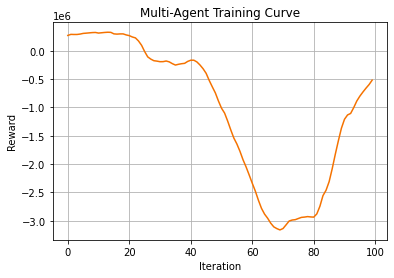

In [18]:
df = results.dataframe()
path = df['logdir'][0]
data = pd.read_csv(path + '/progress.csv')

plt.figure()
plt.plot(data['episode_reward_mean'], c='#f57200')
# plt.plot(data['episode_reward_mean'])
plt.title('Multi-Agent Training Curve')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.grid()
plt.show()

In [ ]:
gym.